In [1]:
import numpy as np
import torch

In [191]:
#parameter setting
num_hidden_state = 3
num_obs = 5
length = 3
num_samples = 1

In [2]:
#define some useful functions
def generate_HMM_params(num_hidden_state, num_obs):
    # random generate the transition matrix and observation matrix, and compute the stationary distribution
    
    alpha_state = np.ones(num_hidden_state)
    alpha_obs = np.ones(num_obs) / num_obs
    trans_mat = np.random.dirichlet(alpha_state, num_hidden_state)
    obs_mat = np.random.dirichlet(alpha_obs, num_hidden_state)
    tmp = np.ones((num_hidden_state + 1, num_hidden_state))
    tmp[:-1] = np.identity(num_hidden_state) - trans_mat.T
    tmp_v = np.zeros(num_hidden_state + 1)
    tmp_v[-1] = 1
    stat_dist = np.linalg.lstsq(tmp, tmp_v, rcond=None)[0]
    return trans_mat, obs_mat, stat_dist

In [4]:
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM
print(trans_mat)
print(obs_mat)
print(stat_dist)
print(stat_dist @ trans_mat)

[[0.31171752 0.14466132 0.54362116]
 [0.48262276 0.41041321 0.10696403]
 [0.63493906 0.18155131 0.18350963]]
[[5.31183612e-03 3.18727100e-01 4.60386268e-01 1.87884837e-01
  2.76899589e-02]
 [1.39397202e-03 1.01159214e-04 8.84424090e-01 2.97764010e-02
  8.43043777e-02]
 [3.88117700e-03 2.36483698e-01 1.76779583e-02 7.20955470e-01
  2.10016963e-02]]
[0.45524953 0.21365455 0.33109592]
[0.45524953 0.21365455 0.33109592]


In [3]:
def generate_HMM_sequences(trans_mat, obs_mat, init_dist, length, num_samples = 1):
    # generate sample sequences from HMM
    
    states = np.zeros((num_samples, length))
    obs = np.zeros((num_samples, length))
    tmp_state = np.argmax(np.random.multinomial(1, init_dist, num_samples), axis = 1)
    #print(tmp_state)
    for i in range(length):
        #print("i: ", i)
        states[:, i] = tmp_state
        for j in range(num_samples):
            obs[j, i] = np.random.multinomial(1, obs_mat[tmp_state[j]]).argmax()
            tmp_state[j] = np.random.multinomial(1, trans_mat[tmp_state[j]]).argmax()
        #print("obs[:, i]: ", obs[:, i])
    return states, obs

In [10]:
test_states, test_obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, 100000)
lst = [0, 0, 0, 0, 0]
for i in range(test_states.shape[0]):
    if (test_states[i, 0] == 0.0): # and (test_states[i, 1] == 2.0):
        lst[int(test_obs[i, 0])] += 1
print(lst)
lst = np.array(lst).astype('float64')
lst /= lst.sum()
print(lst)

[213, 14394, 21011, 8542, 1279]
[0.0046876  0.31677634 0.46240014 0.18798829 0.02814763]


In [4]:
def forward_compute(trans_mat, obs_mat, init_dist, obs_to_pos):
    # compute \sum_{h_1,...,h_{pos-1}} P(h_1,...,h_{pos},x_1,...,x_{pos-1})
    pos = obs_to_pos.shape[0] + 1
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    forward = np.zeros((pos, num_hidden_state))
    forward[0] = init_dist
    for i in range(1, pos):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                #print(i, j, k)
                #print(forward[i - 1, k], trans_mat[k, j], obs_mat[k, int(obs_to_pos[i - 1])])
                forward[i, j] += forward[i - 1, k] * trans_mat[k, j] * obs_mat[k, int(obs_to_pos[i - 1])]
    #print("forward: ", forward)
    return forward[pos - 1]

In [5]:
def backward_compute(trans_mat, obs_mat, obs_from_pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    back_length = obs_from_pos.shape[0]
    if (back_length == 0):
        return np.ones(num_hidden_state)
    backward = np.zeros((back_length, num_hidden_state))
    for j in range(num_hidden_state):
         for k in range(num_hidden_state):
            backward[0, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-1])]
    for i in range(1, back_length):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                backward[i, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-(i + 1)])] * backward[i - 1, k]
    #print("backward: ", backward)
    return backward[-1]

In [6]:
def x_i_conditional_prob(trans_mat, obs_mat, init_dist, known_X, pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    num_samples = known_X.shape[0]
    length = known_X.shape[1]
    x_pos_conditional_prob = np.zeros((num_samples, num_obs))
    h_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    h_all_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    for i in range(num_samples):
        #print("x_i_conditional_prob: i=", i)
        sample_obs_vec = known_X[i]
        forward_vec = forward_compute(trans_mat, obs_mat, init_dist, known_X[i, :pos[i]])
        backward_vec = backward_compute(trans_mat, obs_mat, known_X[i, pos[i] + 1:])
        #print("forward_vec: ", forward_vec)
        #print("backward_vec: ", backward_vec)
        h_prob_tmp = forward_vec * backward_vec
        tmp = h_prob_tmp.sum()
        h_prob_tmp /= tmp
        h_pos_conditional_prob[i] = h_prob_tmp
        x_pos_conditional_prob[i] = h_prob_tmp @ obs_mat
        h_all_pos_conditional_prob[i] = h_prob_tmp * obs_mat[:, int(known_X[i, pos[i]])] / x_pos_conditional_prob[i, int(known_X[i, pos[i]])]
    return h_pos_conditional_prob, x_pos_conditional_prob, h_all_pos_conditional_prob

In [15]:
test_states, test_obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, 100000)
lst = [0, 0, 0]
for i in range(test_states.shape[0]):
    if (test_states[i, 0] == 0.0) and (test_states[i, 1] == 2.0):
        lst[int(test_states[i, 2])] += 1
print(lst)
lst = np.array(lst).astype('float64')
lst /= lst.sum()
print(lst)

[15760, 4543, 4542]
[0.63433286 0.18285369 0.18281344]


In [17]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples)
states, obs

(array([[0., 0., 2.]]), array([[1., 2., 3.]]))

In [18]:
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM

#obs_mat = np.zeros((num_hidden_state, num_obs))
#obs_mat[:, :num_hidden_state] = np.identity(num_hidden_state)

states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)
#pos_one_hot = np.zeros((num_samples, length))
#tmp = np.arange(num_samples)
#pos_one_hot[tmp, pos] = 1
#print(pos_one_hot)
print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states")
print(np.concatenate((states, obs), axis = 1))
print("positions: ", pos)
h, x = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(h)
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(x)

transition matrix
[[0.01554627 0.14416745 0.84028628]
 [0.13160845 0.43043007 0.43796147]
 [0.3378113  0.01195339 0.65023531]]
observation matrix
[[5.10336443e-05 4.22640901e-06 2.08226911e-14 1.80774938e-01
  8.19169802e-01]
 [8.86951621e-01 1.03226795e-01 2.03990342e-03 1.96728311e-03
  5.81439722e-03]
 [3.78728552e-01 1.24232902e-01 1.81257702e-03 4.50485680e-01
  4.47402888e-02]]
stationary distribution
[0.24363546 0.07594781 0.68041673]
states and observations, first half of each row is states
[[2. 2. 2. 0. 0. 0.]]
positions:  [2]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j]:
[[0.28089022 0.12744663 0.59166315]]
Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j]:
[[0.33713306 0.08666112 0.00133241 0.31756441 0.25730899]]


In [20]:
#x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, np.array([1]))
test_states, test_obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, 1000000)
lst = [0, 0, 0, 0, 0]
for i in range(test_states.shape[0]):
    if (test_obs[i, 0] == 0.0) and (test_obs[i, 1] == 0.0):
        lst[int(test_states[i, 2])] += 1
print(lst)
lst = np.array(lst).astype('float64')
lst /= lst.sum()
print(lst)

[28774, 12854, 61110, 0, 0]
[0.28007164 0.12511437 0.59481399 0.         0.        ]


In [10]:
h @ obs_mat, x

(array([[0.26064652, 0.33029826, 0.11729067, 0.04206999, 0.24969456]]),
 array([[0.26064652, 0.33029826, 0.11729067, 0.04206999, 0.24969456]]))

In [7]:
from torch.utils import data

In [8]:
#parameter setting
num_hidden_state = 3
num_obs = 5
length = 10
num_samples = 1000

In [22]:
seed = 20211018
np.random.seed(seed)
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM

states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("random seed:" + str(seed))
print("transition matrix:")
print(trans_mat)
print("observation matrix:")
print(obs_mat)
print("stationary distribution:")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5:")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

random seed:20211018
transition matrix:
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix:
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution:
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5:
[[1. 1. 0. 0. 0. 2. 0. 1. 0. 1. 0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [0. 2. 0. 2. 0. 2. 2. 2. 1. 0. 3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 2. 2. 0. 1. 0. 2. 1. 2. 0. 1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [1. 0. 1. 0. 2. 1. 1. 1. 0. 1. 4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]]
positions, only showing first 5:  [9 4 6 2 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0

In [23]:
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(h)
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(x)
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j]:")
print(hh)

Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j]:
[[0.21892801 0.54738046 0.23369153]
 [0.33619463 0.45004706 0.21375831]
 [0.60101586 0.31777197 0.08121217]
 ...
 [0.41379102 0.41856886 0.16764012]
 [0.27206145 0.58534399 0.14259456]
 [0.09832065 0.65804146 0.24363788]]
Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j]:
[[0.14699655 0.63720383 0.02258836 0.10771679 0.08549447]
 [0.16547851 0.58361774 0.02162021 0.15698083 0.07230271]
 [0.21963904 0.43763689 0.01686816 0.2701232  0.0557327 ]
 ...
 [0.18238158 0.53876658 0.02001439 0.19029037 0.06854707]
 [0.16701796 0.58951492 0.01974422 0.13181047 0.09191243]
 [0.12948606 0.68930578 0.02327471 0.05727722 0.10065623]]
Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j]:
[[8.64084416e-02 5.66936866e-01 3.46654692e-01]
 [5.98534890e-02 9.40146510e-01 1.36456714e-09]
 [3.45386395e-01 4.79209535e-01 1.75404070e-01]
 ...
 [1.93158417e-01 5.12731568e-01 2.94110015e-01]
 [9.04102686e-01 9.58973140e-02 8.521

In [199]:
test_states, test_obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, 1000000)
lst = [0, 0, 0]
for i in range(test_states.shape[0]):
    if (test_obs[i, 0] == 2.0) and (test_obs[i, 1] == 1.0) and (test_obs[i, 2] == 3.0):
        lst[int(test_states[i, 2])] += 1
print(lst)
lst = np.array(lst).astype('float64')
lst /= lst.sum()
print(lst)

[527, 3185, 3864]
[0.06956177 0.42040655 0.51003168]


In [24]:
features, labels = x, h

In [34]:
# Model parameters.
lr = 3
epochs = 2000
batch_size = 100

In [58]:
dataset = data.TensorDataset(torch.FloatTensor(x), torch.FloatTensor(h))
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [59]:
from torch import nn

In [60]:
net = nn.Sequential(nn.Linear(num_obs, num_hidden_state, bias=False))

In [61]:
loss = nn.MSELoss()

In [62]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [63]:
total_loss_lst = []
for i in range(epochs):
    total_loss = 0
    for X, y in train_dl:
        l = loss(net(X) ,y)
        total_loss += l
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if (i % 100 == 0):
        print("epoch: ", i)
        print("loss: ", total_loss)
        total_loss_lst.append(total_loss.item())

epoch:  0
loss:  tensor(0.3347, grad_fn=<AddBackward0>)
epoch:  100
loss:  tensor(0.0069, grad_fn=<AddBackward0>)
epoch:  200
loss:  tensor(0.0055, grad_fn=<AddBackward0>)
epoch:  300
loss:  tensor(0.0043, grad_fn=<AddBackward0>)
epoch:  400
loss:  tensor(0.0034, grad_fn=<AddBackward0>)
epoch:  500
loss:  tensor(0.0027, grad_fn=<AddBackward0>)
epoch:  600
loss:  tensor(0.0021, grad_fn=<AddBackward0>)
epoch:  700
loss:  tensor(0.0017, grad_fn=<AddBackward0>)
epoch:  800
loss:  tensor(0.0013, grad_fn=<AddBackward0>)
epoch:  900
loss:  tensor(0.0010, grad_fn=<AddBackward0>)
epoch:  1000
loss:  tensor(0.0008, grad_fn=<AddBackward0>)
epoch:  1100
loss:  tensor(0.0006, grad_fn=<AddBackward0>)
epoch:  1200
loss:  tensor(0.0005, grad_fn=<AddBackward0>)
epoch:  1300
loss:  tensor(0.0004, grad_fn=<AddBackward0>)
epoch:  1400
loss:  tensor(0.0003, grad_fn=<AddBackward0>)
epoch:  1500
loss:  tensor(0.0002, grad_fn=<AddBackward0>)
epoch:  1600
loss:  tensor(0.0002, grad_fn=<AddBackward0>)
epoch:  1

In [64]:
total_loss_lst

[0.33469662070274353,
 0.0069283959455788136,
 0.005458314903080463,
 0.004300158005207777,
 0.003387742443010211,
 0.0026689220685511827,
 0.0021026271861046553,
 0.001656488049775362,
 0.0013050104025751352,
 0.0010281108552590013,
 0.000809963617939502,
 0.0006381042767316103,
 0.0005027090664952993,
 0.00039604518678970635,
 0.0003120098845101893,
 0.00024580745957791805,
 0.00019365159096196294,
 0.0001525621919427067,
 0.00012019075074931607,
 9.468877397011966e-05]

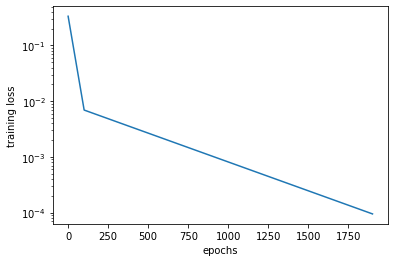

In [75]:
import matplotlib.pyplot as plt
x_lst = list(range(0, 2000, 100))
plt.plot(x_lst, total_loss_lst)
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.show()

In [83]:
print("learned matrix:")
print(net[0].weight.data.T.numpy())
print("pseudo-inv of O:")
print(np.linalg.pinv(obs_mat))
print("Frob norm of difference:" + str(np.linalg.norm(net[0].weight.data.T.numpy()-np.linalg.pinv(obs_mat))))

learned matrix:
[[ 0.33444914  2.606148   -1.7460089 ]
 [-0.01350728  0.07900791  0.98299867]
 [-0.03453552 -0.19923699  0.5129726 ]
 [ 2.088948   -1.8289478   0.6197184 ]
 [-0.54350334  3.745206   -2.5466576 ]]
pseudo-inv of O:
[[ 5.33398346e-01  2.62833064e+00 -1.97029301e+00]
 [-9.48583761e-03 -2.97974301e-03  1.06001933e+00]
 [ 9.08540466e-02 -4.56127065e-01  3.45443693e-01]
 [ 1.96231049e+00 -1.81806331e+00  7.42823603e-01]
 [-7.82054374e-01  4.31680259e+00 -2.80659284e+00]]
Frob norm of difference:0.8338665632026157


In [77]:
np.linalg.pinv(obs_mat)

array([[ 5.33398346e-01,  2.62833064e+00, -1.97029301e+00],
       [-9.48583761e-03, -2.97974301e-03,  1.06001933e+00],
       [ 9.08540466e-02, -4.56127065e-01,  3.45443693e-01],
       [ 1.96231049e+00, -1.81806331e+00,  7.42823603e-01],
       [-7.82054374e-01,  4.31680259e+00, -2.80659284e+00]])

In [78]:
for X, y in train_dl:
    print(X[:9])
    print(y[:9])
    print((X @ net[0].weight.data.T - y)[:9])
    print((X.double() @ torch.from_numpy(np.linalg.pinv(obs_mat)))[:9])
    print(net[0].weight.data.T.double() - torch.from_numpy(np.linalg.pinv(obs_mat)))
    break

tensor([[0.1470, 0.6372, 0.0226, 0.1077, 0.0855],
        [0.1655, 0.5836, 0.0216, 0.1570, 0.0723],
        [0.2196, 0.4376, 0.0169, 0.2701, 0.0557],
        [0.1634, 0.6010, 0.0197, 0.1192, 0.0966],
        [0.2299, 0.4131, 0.0154, 0.2828, 0.0588],
        [0.2056, 0.4799, 0.0173, 0.2281, 0.0690],
        [0.1830, 0.5376, 0.0199, 0.1903, 0.0693],
        [0.1513, 0.6227, 0.0227, 0.1251, 0.0783],
        [0.1351, 0.6725, 0.0231, 0.0737, 0.0956]])
tensor([[0.2189, 0.5474, 0.2337],
        [0.3362, 0.4500, 0.2138],
        [0.6010, 0.3178, 0.0812],
        [0.2416, 0.6192, 0.1392],
        [0.6292, 0.3354, 0.0355],
        [0.5004, 0.4144, 0.0852],
        [0.4135, 0.4236, 0.1629],
        [0.2611, 0.4959, 0.2430],
        [0.1376, 0.6214, 0.2411]])
tensor([[-6.0388e-04,  4.7440e-03, -3.3621e-03],
        [-8.5226e-04,  6.6962e-03, -4.7455e-03],
        [-6.9201e-05,  5.4520e-04, -3.8634e-04],
        [ 7.3947e-04, -5.8121e-03,  4.1189e-03],
        [ 5.0008e-04, -3.9281e-03,  2.7840e-03

In [109]:
x, h

(array([[0.10659928, 0.02308308, 0.30843146, 0.04712147, 0.51476471],
        [0.11266594, 0.02707417, 0.3144569 , 0.05527557, 0.49052742],
        [0.10924114, 0.04002508, 0.2982135 , 0.08161441, 0.47090587],
        ...,
        [0.12111725, 0.01954281, 0.33390811, 0.0399925 , 0.48543933],
        [0.08804524, 0.07371188, 0.23693078, 0.15006043, 0.45125167],
        [0.08846542, 0.0729027 , 0.23826504, 0.14841584, 0.45195101]]),
 array([[0.3369734 , 0.54410674, 0.11891986],
        [0.35988624, 0.50046146, 0.13965229],
        [0.35111199, 0.44198166, 0.20690635],
        ...,
        [0.38822297, 0.51122894, 0.10054809],
        [0.28409307, 0.33407683, 0.38183009],
        [0.28538292, 0.33698888, 0.3776282 ]]))

In [116]:
np.linalg.pinv(obs_mat)

array([[ 0.70946001, -0.25856422,  0.16254959],
       [ 0.13386227, -0.53187938,  1.00319817],
       [ 1.33246609, -0.05937896, -0.08454823],
       [ 0.27525784, -1.08351973,  2.04118875],
       [-0.32187423,  1.26915907,  0.01617982]])

In [182]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states")
print(np.concatenate((states, obs), axis = 1))
print("positions: ", pos)
h, x = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)

transition matrix
[[0.42265632 0.22411211 0.35323157]
 [0.46122757 0.40080087 0.13797155]
 [0.04676753 0.5609235  0.39230897]]
observation matrix
[[2.92681512e-01 1.50206764e-04 6.16017949e-01 1.42344315e-03
  8.97268893e-02]
 [1.46534926e-02 2.00898243e-04 1.85346850e-01 7.24383169e-05
  7.99726321e-01]
 [2.77131417e-06 1.92761368e-01 1.11532894e-05 3.91880687e-01
  4.15344020e-01]]
stationary distribution
[0.33200907 0.38711344 0.28087749]
states and observations, first half of each row is states
[[0. 0. 0. ... 4. 4. 4.]
 [2. 2. 2. ... 4. 3. 4.]
 [2. 1. 1. ... 4. 1. 4.]
 ...
 [0. 0. 1. ... 2. 4. 4.]
 [1. 1. 2. ... 4. 4. 4.]
 [2. 1. 0. ... 4. 4. 4.]]
positions:  [9 7 6 7 1 1 5 5 4 3 4 0 8 0 0 7 1 3 3 1 7 8 3 7 1 0 9 8 0 6 2 0 0 9 4 4 8
 0 8 1 9 4 3 3 3 4 9 2 6 4 1 7 0 0 6 8 5 4 5 1 5 9 1 7 7 7 9 7 4 8 9 8 2 3
 6 6 7 8 3 6 6 3 2 7 0 9 8 6 8 4 6 1 7 4 2 8 9 1 9 8 8 1 6 5 6 1 3 6 6 7 9
 3 5 0 6 4 6 3 0 6 3 8 9 0 0 4 6 7 8 9 5 4 6 3 2 8 6 0 9 2 4 0 1 5 3 8 6 2
 6 6 3 4 9 7 7 5 1 4 4 0 2 3

In [186]:
torch.from_numpy(x) @ net[0].weight.data.T.double() - torch.from_numpy(h)

tensor([[ 5.2449e-09, -8.7515e-08,  9.4320e-08],
        [-2.3336e-07,  4.2445e-07, -3.8074e-07],
        [-1.5459e-07,  2.8853e-07, -2.7494e-07],
        ...,
        [-7.1988e-08,  8.2092e-09,  4.8466e-08],
        [-2.2446e-08,  1.4187e-08, -2.6014e-08],
        [-1.3576e-07,  2.3927e-07, -2.2379e-07]], dtype=torch.float64)

In [201]:
logh = np.log(h)

array([[-0.9488476 , -1.6940934 , -0.84618815]])

In [84]:
net.eval()

Sequential(
  (0): Linear(in_features=5, out_features=3, bias=False)
)

In [85]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix:")
print(trans_mat)
print("observation matrix:")
print(obs_mat)
print("stationary distribution:")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5:")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix:
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix:
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution:
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5:
[[0. 1. 0. 0. 2. 1. 0. 2. 0. 2. 0. 0. 0. 0. 1. 0. 3. 1. 1. 1.]
 [0. 2. 0. 1. 1. 0. 2. 1. 0. 1. 3. 1. 3. 4. 1. 3. 1. 4. 0. 1.]
 [1. 0. 1. 0. 2. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]
 [2. 0. 0. 1. 0. 1. 0. 2. 2. 1. 1. 1. 1. 1. 1. 4. 3. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 3. 1. 1. 1. 1. 1. 0. 1. 1. 1.]]
positions, only showing first 5:  [2 2 5 8 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.2431274  0.58828537 

In [98]:
test_dataset = data.TensorDataset(torch.FloatTensor(x), torch.FloatTensor(h))
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=False)

In [104]:
for X, Y in test_dl:
    print(np.linalg.norm((net(X) - Y).detach().numpy()) / num_samples)
    break

0.0001440732181072235


In [95]:
x[:9], h[:9]

(array([[0.15946675, 0.60874808, 0.02060083, 0.1192001 , 0.09198425],
        [0.22107884, 0.43541637, 0.01645414, 0.26844003, 0.05861061],
        [0.18015247, 0.55284895, 0.01881084, 0.16282026, 0.08536747],
        [0.19425925, 0.51335119, 0.01782875, 0.19645788, 0.07810293],
        [0.15273475, 0.61885535, 0.02258431, 0.12784731, 0.07797827],
        [0.14444756, 0.64402029, 0.02282135, 0.10254428, 0.08616652],
        [0.13312961, 0.67788521, 0.02323228, 0.06940934, 0.09634355],
        [0.22088319, 0.43291219, 0.01699663, 0.27659684, 0.05261115],
        [0.17402433, 0.57167964, 0.01894767, 0.14348231, 0.09186606]]),
 array([[0.2431274 , 0.58828537, 0.16858724],
        [0.59621374, 0.33723514, 0.06655112],
        [0.34529973, 0.53576977, 0.11893049],
        [0.42479842, 0.48089777, 0.0943038 ],
        [0.26754286, 0.49347438, 0.23898276],
        [0.20684923, 0.55285937, 0.2402914 ],
        [0.12754834, 0.62699737, 0.24545429],
        [0.61688051, 0.29575285, 0.08736664],
